# `nsgaiii`: Understanding NSGA-III selection
## [Luis Martí](http://lmarti.com)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lmarti/nsgaiii/blob/master/NSGA-III%20in%20Python.ipynb)

In this notebook we will explore NSGA-III via an illustrative implementation in Python, that is distributed as the [`nsgaiii` module](https://github.com/lmarti/nsgaiii).

⚠️ **Important notice:** The `nsgaiii` code has been integrated in [DEAP](https://github.com/DEAP/deap) as their function [`selNSGA3`](https://github.com/DEAP/deap/blob/master/deap/tools/emo.py#L492). I recommend you use that implementation as it is actively maintained.

## Preparing the environment

We start by installing required packages and importing them.

In [1]:
%pip -q install numpy deap matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import array
import copy

import random

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import numpy as np
from deap import algorithms, base, benchmarks, creator, tools
from deap.tools.indicator import hv

In [3]:
from nsgaiii.selection import (
    associate,
    construct_hyperplane,
    find_extreme_points,
    find_ideal_point,
    generate_reference_points,
    normalize_objectives,
    sel_nsga_iii,
)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Understanding the NSGA-III selection mechanism

In order to understand the NSGA-III selection mechanism we will make an example iteration of solving a three-objectives [DTLZ2 problem](https://deap.readthedocs.io/en/master/api/benchmarks.html#deap.benchmarks.dtlz2).

[![DTLZ2 Problem](https://pymoo.org/_images/problems_many_dtlz_18_1.png)](https://pymoo.org/problems/many/dtlz.html).

In [5]:
creator.create("FitnessMin3", base.Fitness, weights=(-1.0,) * 3)
creator.create("Individual3", array.array, typecode="d", fitness=creator.FitnessMin3)

The `toolbox` contains the configuration of the algorithm:

* how to create an individual,
* how to create a population,
* the evolutionary operators,
* the evaluation function, and
* the selection method.

The `prepare_toolbox()` function encapsulates the configuration.

In [6]:
def prepare_toolbox(
    problem_instance, selection_func, number_of_variables, bounds_low, bounds_up
):
    def uniform(low, up, size=None):
        try:
            return [random.uniform(a, b) for a, b in zip(low, up)]
        except TypeError:
            return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

    toolbox = base.Toolbox()

    toolbox.register("evaluate", problem_instance)
    toolbox.register("select", selection_func)

    toolbox.register("attr_float", uniform, bounds_low, bounds_up, number_of_variables)
    toolbox.register(
        "individual", tools.initIterate, creator.Individual3, toolbox.attr_float
    )
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register(
        "mate", tools.cxSimulatedBinaryBounded, low=bounds_low, up=bounds_up, eta=20.0
    )
    toolbox.register(
        "mutate",
        tools.mutPolynomialBounded,
        low=bounds_low,
        up=bounds_up,
        eta=20.0,
        indpb=1.0 / number_of_variables,
    )

    toolbox.pop_size = 42  # population size
    toolbox.max_gen = 200  # max number of iterations
    toolbox.mut_prob = 1 / number_of_variables
    toolbox.cross_prob = 0.29

    return toolbox

Preparing an instance of `toolbox`:

In [7]:
number_of_variables = 30

In [8]:
bounds_low, bounds_up = 0, 1

In [9]:
toolbox = prepare_toolbox(
    lambda ind: benchmarks.dtlz2(ind, 3),
    sel_nsga_iii,
    number_of_variables,
    bounds_low,
    bounds_up,
)

## Visualizing reference point selection

Creating a population and evaluating it.

In [10]:
pop = toolbox.population(n=42)

In [11]:
for ind in pop:
    ind.fitness.values = toolbox.evaluate(ind)

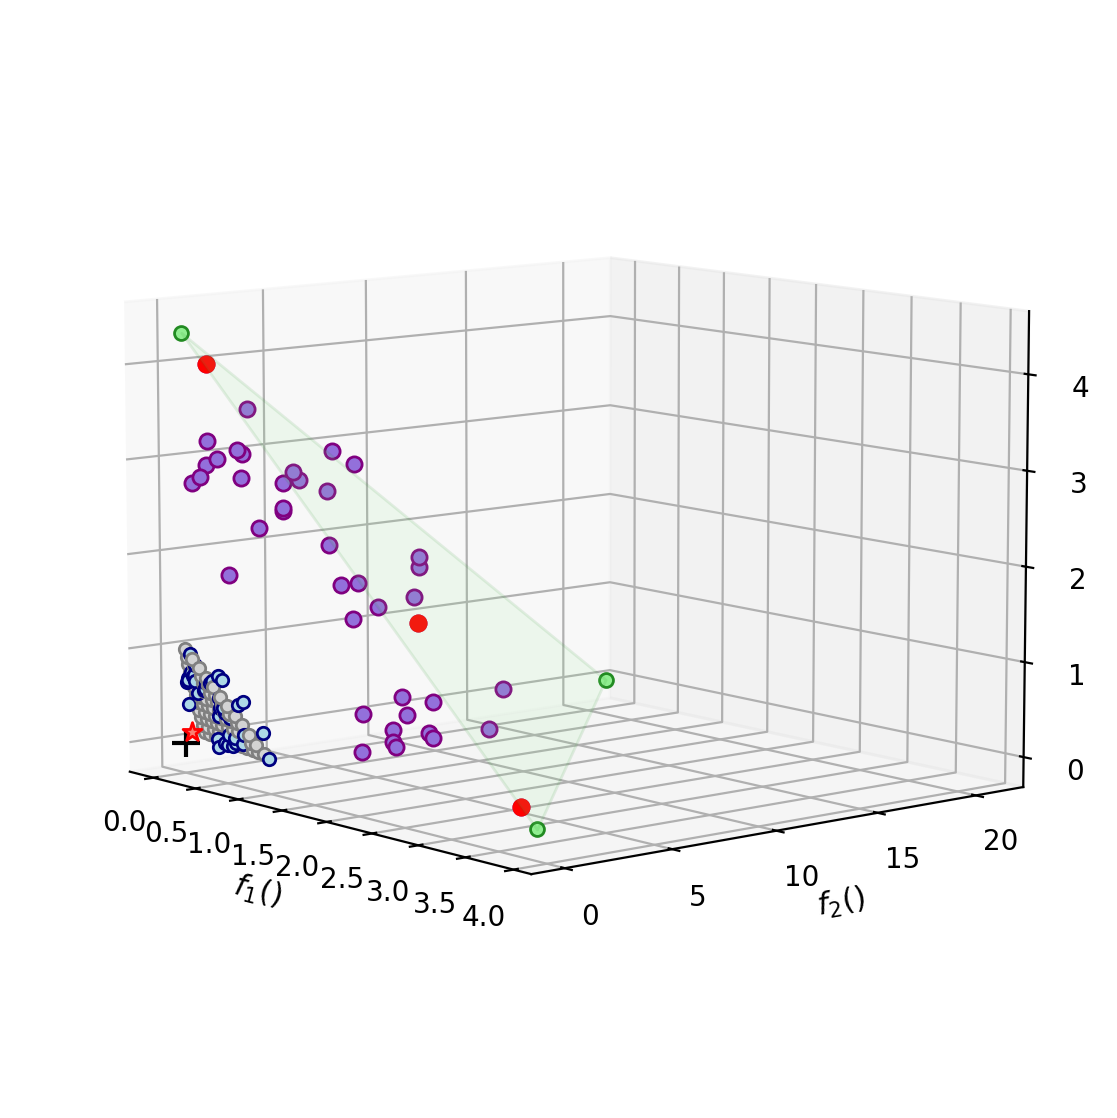

In [12]:
fig = plt.figure(
    figsize=(7, 7),
)
ax = fig.add_subplot(111, projection="3d")

# the coordinate origin (black + sign)
ax.scatter(0, 0, 0, c="k", marker="+", s=100)

# the population (purple)
for ind in pop:
    ax.scatter(
        ind.fitness.values[0],
        ind.fitness.values[1],
        ind.fitness.values[2],
        edgecolors="purple",
        facecolors="mediumpurple",
        s=30,
        marker="o",
    )

# ideal point (red star)
ideal_point = find_ideal_point(pop)
ax.scatter(
    ideal_point[0],
    ideal_point[1],
    ideal_point[2],
    s=50,
    marker="*",
    facecolors="salmon",
    edgecolors="red",
)

# extreme points marked (red)
extremes = find_extreme_points(pop)
for i, ex in enumerate(extremes):
    ax.scatter(
        ex.fitness.values[0],
        ex.fitness.values[1],
        ex.fitness.values[2],
        s=30,
        facecolors="r",
        marker="o",
        edgecolors="r",
    )

# intercepts (in green)
intercepts = construct_hyperplane(pop, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(
        vert[0],
        vert[1],
        vert[2],
        facecolors="lightgreen",
        edgecolors="forestgreen",
        s=100,
        marker=".",
    )

tri = a3.art3d.Poly3DCollection([verts])
tri.set_color("lightgreen")
tri.set_alpha(0.11)
tri.set_edgecolor("forestgreen")
ax.add_collection3d(tri)

# normalized objectives (light blue)
normalize_objectives(pop, intercepts, ideal_point)

for ind in pop:
    ax.scatter(
        ind.fitness.normalized_values[0],
        ind.fitness.normalized_values[1],
        ind.fitness.normalized_values[2],
        edgecolors="navy",
        marker="o",
        facecolors="lightblue",
    )

# reference points (gray)
rps = generate_reference_points(3)
for rp in rps:
    ax.scatter(
        rp[0], rp[1], rp[2], marker="o", facecolors="lightgray", edgecolors="gray"
    )

# final figure details
ax.set_xlabel("$f_1()$", fontsize=11)
ax.set_ylabel("$f_2()$", fontsize=11)
ax.set_zlabel("$f_3()$", fontsize=11)
ax.view_init(elev=9, azim=-40)
ax.set_box_aspect(aspect=None, zoom=0.92)

Associating individuals to reference points.

In [13]:
associate(pop, rps)

Resulting associations

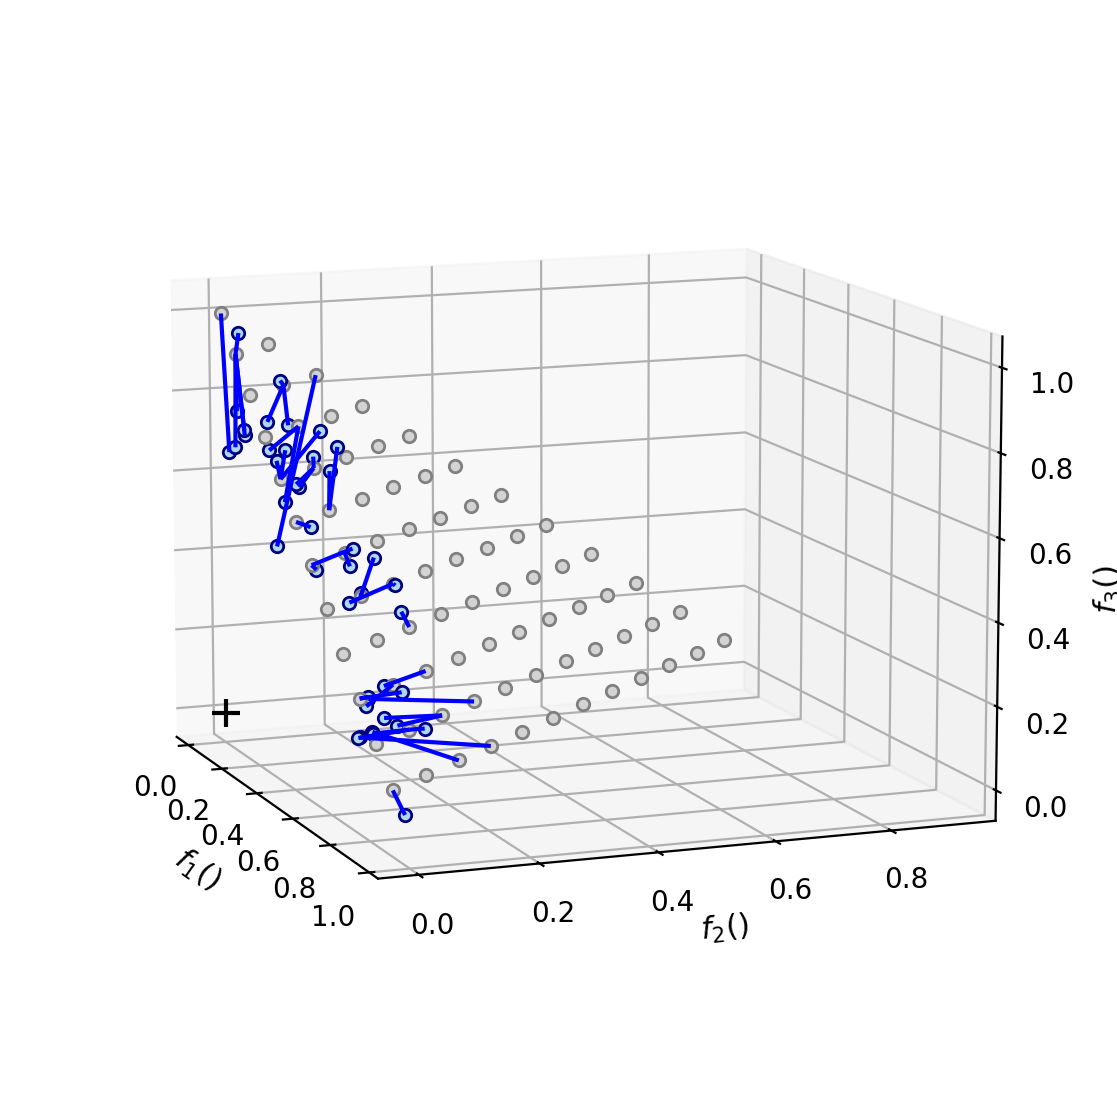

In [14]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

# the coordinate origin
ax.scatter(0, 0, 0, c="k", marker="+", s=100)

for rp in rps:
    ax.scatter(
        rp[0], rp[1], rp[2], marker="o", facecolors="lightgray", edgecolors="gray"
    )

pairs = []
for ind in pop:
    ax.scatter(
        ind.fitness.normalized_values[0],
        ind.fitness.normalized_values[1],
        ind.fitness.normalized_values[2],
        edgecolors="navy",
        marker="o",
        facecolors="lightblue",
    )
    pairs += [(ind.fitness.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color("blue")
ax.add_collection3d(lin)

# final figure details
ax.set_xlabel("$f_1()$", fontsize=11)
ax.set_ylabel("$f_2()$", fontsize=11)
ax.set_zlabel("$f_3()$", fontsize=11)
ax.view_init(elev=11, azim=-21)
ax.set_box_aspect(aspect=None, zoom=0.92)

## Putting it all together and running NSGA-III

Having the selection mechanism the implementantion of NSGA-III is very simple thanks to DEAP.

In [15]:
def nsga_iii(toolbox, stats=None, verbose=False):
    population = toolbox.population(n=toolbox.pop_size)
    return algorithms.eaMuPlusLambda(
        population,
        toolbox,
        mu=toolbox.pop_size,
        lambda_=toolbox.pop_size,
        cxpb=toolbox.cross_prob,
        mutpb=toolbox.mut_prob,
        ngen=toolbox.max_gen,
        stats=stats,
        verbose=verbose,
    )

We create a `Statistics` instance to store the populations in every iteration.

In [16]:
stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

Running NSGA-III...

In [17]:
res, logbook = nsga_iii(
    toolbox, stats=stats, verbose=False
)  # set verbose=True if you want

Resulting population.

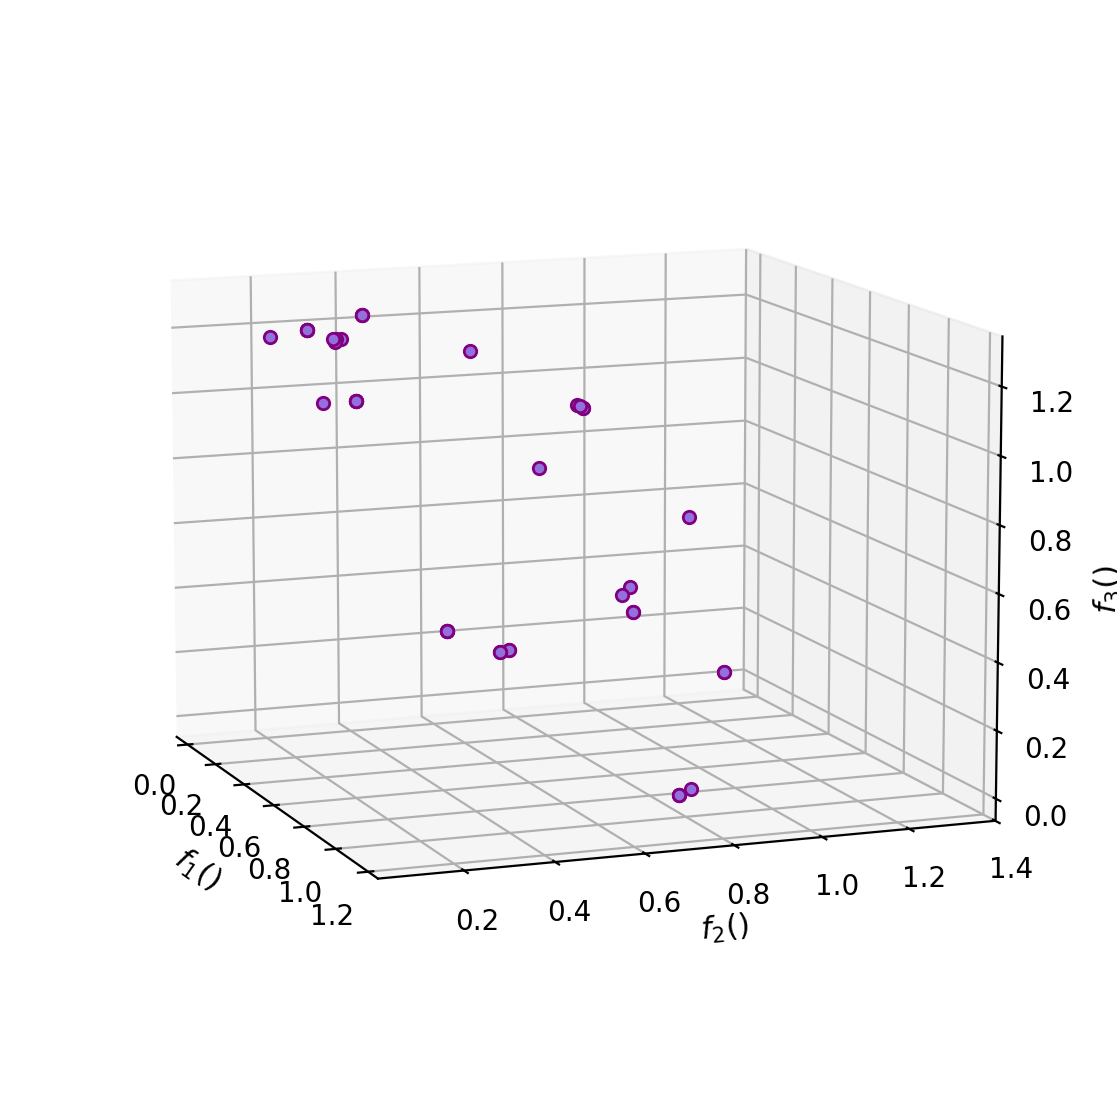

In [18]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

for ind in res:
    ax.scatter(
        ind.fitness.values[0],
        ind.fitness.values[1],
        ind.fitness.values[2],
        edgecolors="purple",
        marker="o",
        facecolors="mediumpurple",
    )

ax.set_xlabel("$f_1()$", fontsize=11)
ax.set_ylabel("$f_2()$", fontsize=11)
ax.set_zlabel("$f_3()$", fontsize=11)
ax.view_init(elev=11, azim=-21)
ax.set_box_aspect(aspect=None, zoom=0.92)

### Plotting hypervolume

In [19]:
pops = logbook.select("pop")

In [20]:
def hypervolume(individuals, ref=None):
    front = tools.sortLogNondominated(
        individuals, len(individuals), first_front_only=True
    )
    wobjs = np.array([ind.fitness.wvalues for ind in front]) * -1
    if ref is None:
        ref = np.max(wobjs, axis=0) + 1
    return hv.hypervolume(wobjs, ref)

In [21]:
pops_obj = [np.array([ind.fitness.wvalues for ind in pop]) * -1 for pop in pops]

In [22]:
ref = np.max([np.max(wobjs, axis=0) for wobjs in pops_obj], axis=0) + 1

In [23]:
hypervols = [hypervolume(pop, ref) for pop in pops]

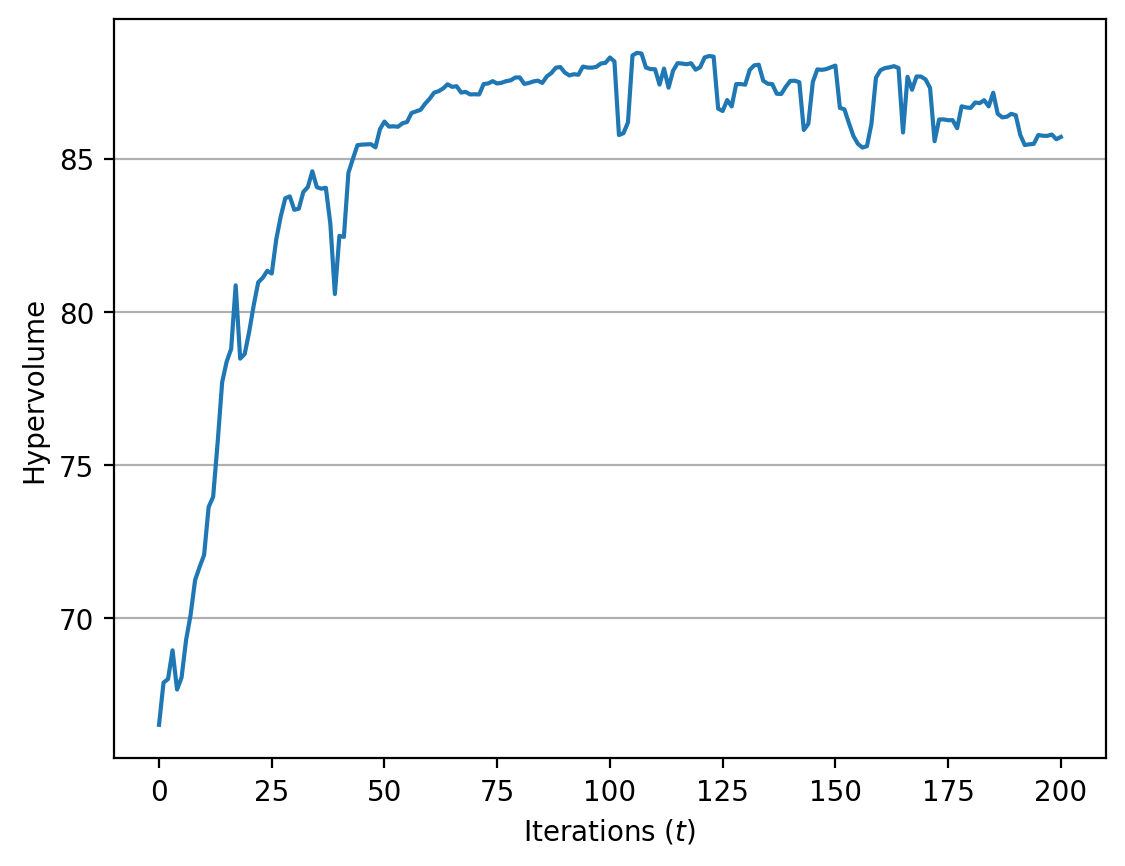

In [24]:
plt.plot(hypervols)
plt.xlabel("Iterations ($t$)")
plt.ylabel("Hypervolume")
plt.grid(axis="y")

## ...that's all!